In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
import xgboost as xgb

from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
xl = pd.ExcelFile('./resources/dataset/2023-04-13_KitaTable_Final.xlsx')

In [4]:
allied = xl.parse('All_Projects_Allied')
projects = xl.parse('Projects')
issuances = xl.parse('Issuances')
retirements = xl.parse('Credits')
buffer = xl.parse('Buffer')
countries = xl.parse('Countries')
methodologies = xl.parse('Methodologies')

In [5]:
def credits_to_vintages(df, credit_type):
    grouped = df.groupby(['RegistryID', 'Vintage']) \
                .agg(credit = ('Amount', 'sum')) \
                .rename({'credit': credit_type}, axis=1) \
                .reset_index()
    grouped['VintageNum'] = grouped.groupby('RegistryID').cumcount() + 1
    
    pivot = pd.pivot(grouped, index = 'RegistryID', columns = 'VintageNum', values = credit_type)
    
    pivot_sum = pivot.sum(axis=1)
    vintage_pivot = pivot \
                        .loc[:, 1:3] \
                        .rename({
                            1: f'{credit_type}_FirstVintage',
                            2: f'{credit_type}_SecondVintage',
                            3: f'{credit_type}_ThirdVintage',
                            }, axis=1)
    
    vintage_pivot[f'Total{credit_type}'] = pivot_sum
    
    return vintage_pivot

In [6]:
issued_vintage = credits_to_vintages(issuances, 'IssuedCredits')
retired_vintage = credits_to_vintages(retirements, 'RetiredCredits')
buffer_grouped = buffer.groupby('RegistryID').agg(Buffer = ('Amount', 'sum'))

In [7]:
credits = pd.concat([issued_vintage, retired_vintage, buffer_grouped], axis=1).reset_index()

In [8]:
project_info = pd.merge(
    pd.merge(allied, countries, left_on = 'Country', right_on = 'CountryCodeA3', how='left'),
    methodologies,
    left_on = 'Methodology',
    right_on = 'MethodologyID',
    how='left',
    suffixes = ('_Projects', '_Methods')
)

In [9]:
merged = pd.merge(project_info, credits, left_on='Registry ID ', right_on='RegistryID', how='left')

In [10]:
columns_epi = ['AMP.raw.2022', 'APR.raw.2020', 'BCA.raw.2019', 'BHV.raw.2020', 'BLC.raw.2019',
           'CDA.raw.2019', 'CDL.raw.2017', 'CDO.raw.2019', 'CH4.raw.2019', 'CHA.raw.2019', 
           'COE.raw.2019', 'CXN.raw.2019', 'EEZ.raw.2022', 'FGA.raw.2019', 'FOG.raw.2019', 
           'FSS.raw.2018', 'FTD.raw.2018', 'GDB.raw.2020', 'GDP.raw.2020', 'GHG.raw.2019', 
           'GHI.raw.2019', 'GHN.raw.2019', 'GHP.raw.2019', 'GIB.raw.2019', 'GL5.raw.2020', 
           'GPC.raw.2020', 'GRA.raw.2020', 'GRL.raw.2020', 'HAD.raw.2019', 'LCB.raw.2017', 
           'MPA.raw.2022', 'MSW.raw.2019', 'NDA.raw.2019', 'NOE.raw.2019', 'NOT.raw.2019', 
           'NOX.raw.2019', 'NXA.raw.2019', 'OCP.raw.2020', 'OZD.raw.2019', 'PAR.raw.2020', 
           'PBD.raw.2019', 'PDN.raw.2020', 'PMD.raw.2019', 'POP.raw.2020', 'PST.raw.2020', 
           'REC.raw.2020', 'RMS.raw.2018', 'SDA.raw.2019', 'SHI.raw.2014', 'SNM.raw.2015', 
           'SO2.raw.2019', 'SOE.raw.2019', 'SPI.raw.2021', 'SPU.raw.2020', 'TBG.raw.2022', 
           'TBN.raw.2022', 'TC5.raw.2020', 'TCA.raw.2000', 'TCC.raw.2020', 'TCL.raw.2020', 
           'USD.raw.2019', 'UWD.raw.2019', 'VOE.raw.2019', 'WL5.raw.2020', 'WST.raw.2019', 
           'WTA.raw.2020', 'WTL.raw.2020', 'WWT.raw.2020']

columns_wgi = ['WGI_VNA_2021', 'WGI_SNV_2021', 'WGI_GE_2021', 'WGI_RQ_2021', 'WGI_ROL_2021', 'WGI_COC_2021']

In [11]:
# model_df = pd.concat([
#     merged.loc[:, columns_epi],
#     merged.loc[:, columns_wgi],
#     merged.loc[:, ['Est.  Annual Emission Reduction', 'Sector_Methods']],
#     merged.loc[:, 'IssuedCredits_FirstVintage':'Buffer'],
#     merged.loc[:, 'Avg. Est Transaction Price']
# ], axis=1)

In [12]:
# model_df = pd.concat([
#     merged.loc[:, ['EstAnnualReductions', 'Sector']],
#     merged.loc[:, 'AMP.raw.1990':'WGI_COC_2021'],
#     merged.loc[:, 'IssuedCredits_FirstVintage':'Buffer'],
#     merged.loc[:, 'Status']
# ], axis=1)

In [13]:
model_df = pd.concat([
    merged.loc[:, ['Registry ID ','Sector_Methods', 'EPI.new', 'Est.  Annual Emission Reduction', 
                   'Avg. Est Transaction Price', 'Registry']],
    merged.loc[:, 'IssuedCredits_FirstVintage':'Buffer']
], axis=1)

In [14]:
# model_df = pd.concat([
#     merged.loc[:, ['Est.  Annual Emission Reduction', 'Sector_Methods']],
#     merged.loc[:, 'EPI.new'],
#     merged.loc[:, 'IssuedCredits_FirstVintage':'Buffer'],
#     merged.loc[:, 'Avg. Est Transaction Price']
# ], axis=1)

In [15]:
model_df['WGI'] = merged.loc[:, ['WGI_VNA_2021', 'WGI_SNV_2021', 'WGI_GE_2021', 
                                        'WGI_RQ_2021', 'WGI_ROL_2021', 'WGI_COC_2021']].mean(axis=1)

In [16]:
# model_df.drop(['Est.  Annual Emission Reduction', 'Buffer'], axis=1, inplace=True)

In [17]:
model_df.dropna(subset = ['Est.  Annual Emission Reduction','Avg. Est Transaction Price'], inplace=True)

In [18]:
model_df.head()

,Registry ID,Sector_Methods,EPI.new,Est. Annual Emission Reduction,Avg. Est Transaction Price,Registry,IssuedCredits_FirstVintage,IssuedCredits_SecondVintage,IssuedCredits_ThirdVintage,TotalIssuedCredits,RetiredCredits_FirstVintage,RetiredCredits_SecondVintage,RetiredCredits_ThirdVintage,TotalRetiredCredits,Buffer,WGI
0,VCS674,Nature Based Solution,28.2,3527171.0,8.56,VCS,5480000.0,1758587.0,1486928.0,33625616.0,1090676.0,2305237.0,2147751.0,23056444.0,4376475.0,48.911327
1,VCS902,Nature Based Solution,46.2,6550464.0,8.26,VCS,2000000.0,416549.0,1910730.0,26822953.0,2751549.0,3617535.0,2035469.0,21251993.0,5049473.0,11.347559
2,VCS1566,Nature Based Solution,42.4,3622352.0,6.04,VCS,3417083.0,7295806.0,6301000.0,25215479.0,3615316.0,7097563.0,6361554.0,19034338.0,4724188.0,43.414193
3,VCS1477,Nature Based Solution,28.2,7451846.0,6.97,VCS,2023000.0,9034817.0,11040984.0,38581777.0,8870585.0,246963.0,1576358.0,13297389.0,4216585.0,48.911327
4,VCS985,Nature Based Solution,39.8,1575268.0,8.23,VCS,276.0,40646.0,15000.0,25240371.0,4506911.0,1728135.0,2215767.0,10741137.0,2804486.0,40.805545


In [19]:
model_df = pd.get_dummies(model_df, columns = ['Sector_Methods', 'Registry'], drop_first = True)
# model_df.drop([
#     'Sector_Methods_Household Devices', 'Sector_Methods_Industrial Process', 'Sector_Methods_Waste'
# ], axis=1, inplace=True)

In [20]:
model_df = model_df.fillna(0)

In [21]:
model_df = model_df[model_df['Registry ID '] != 'VCS2250']

In [22]:
# model_df.to_csv('./Boruta_Regression_2.csv', index=False)

/var/folders/sy/9ql7bb61517dkxr4qj1vgnx80000gn/T/ipykernel_15849/4204270750.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  model_df.corr().loc['Avg. Est Transaction Price'].sort_values().plot(kind='barh')


<Axes: >

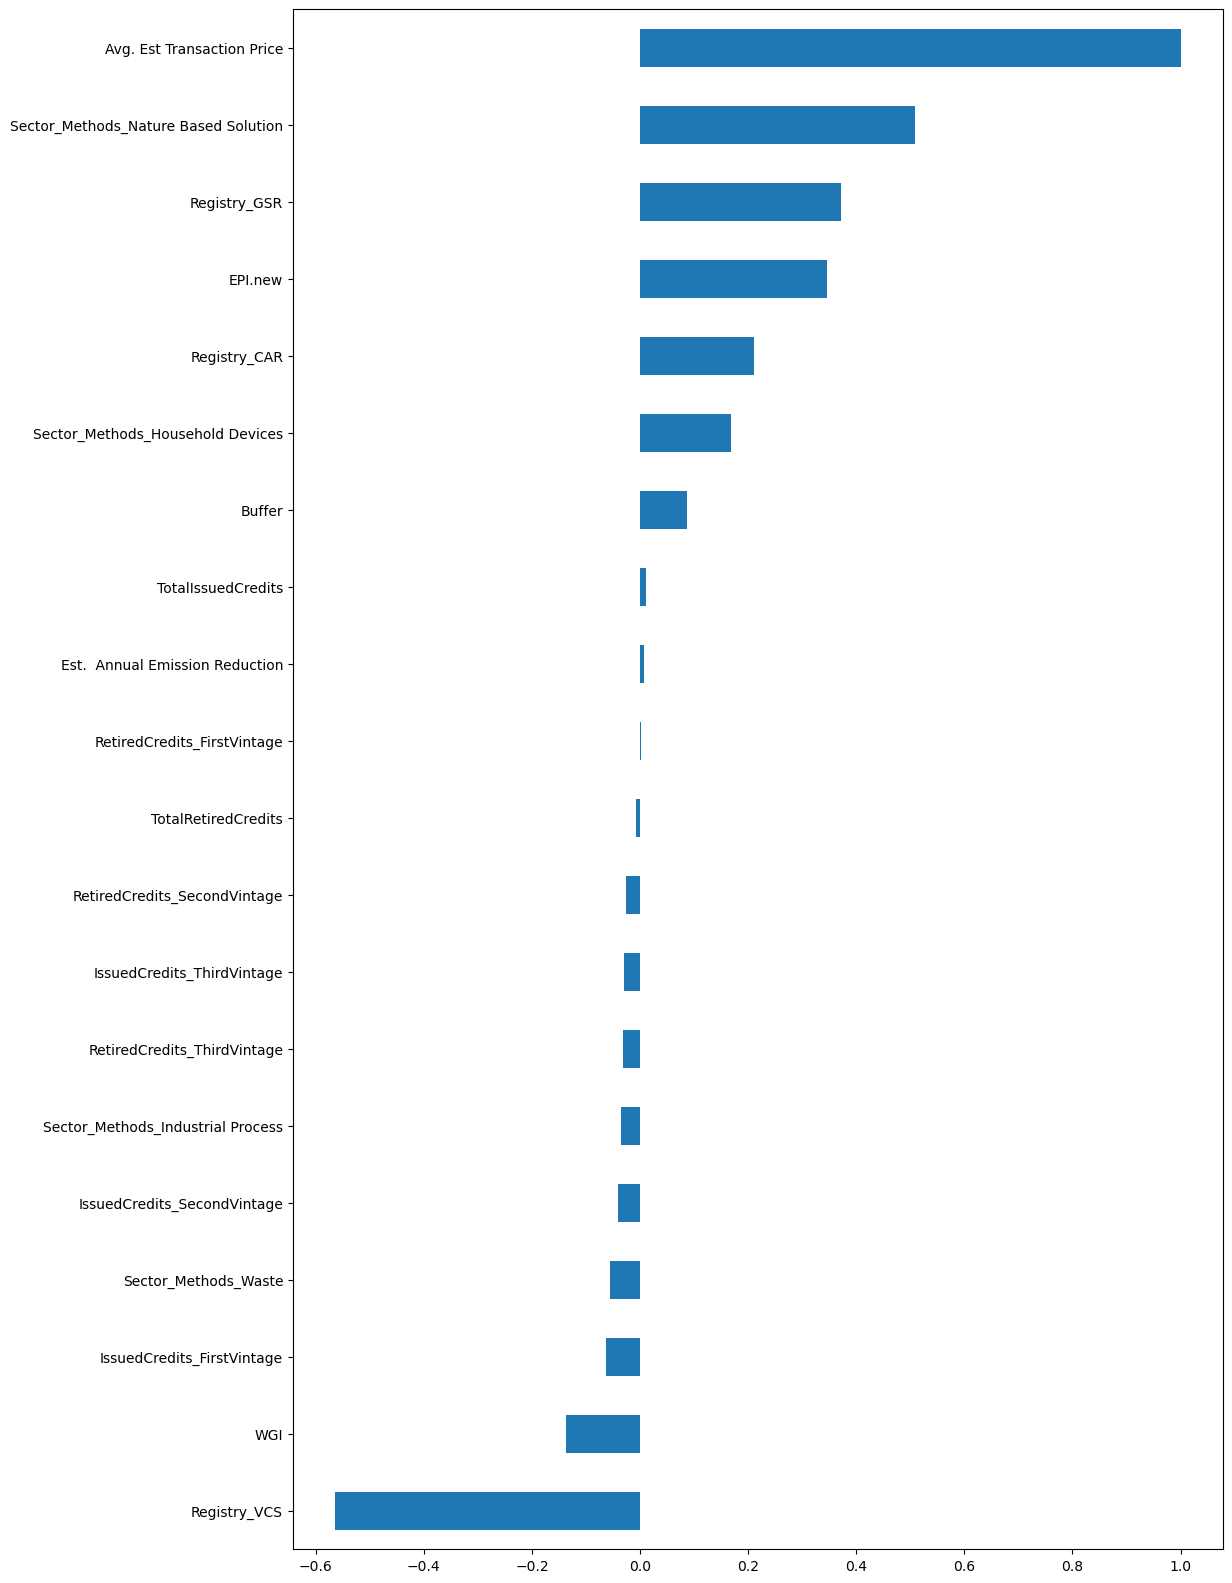

In [23]:
plt.figure(figsize=(12, 20))
model_df.corr().loc['Avg. Est Transaction Price'].sort_values().plot(kind='barh')

In [24]:
# col_filter_ = ['IssuedCredits_FirstVintage', 'WGI', 'EPI.new', 'Buffer', 'Sector_Methods_Nature Based Solution',
#               'Registry_VCS', 'Registry_GSR', 'Registry_CAR']

In [25]:
X = model_df.drop(['Registry ID ', 'Avg. Est Transaction Price'], axis=1).values
y = model_df['Avg. Est Transaction Price'].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [27]:
rfr = RandomForestRegressor(n_estimators=300, random_state=123)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=123)

In [28]:
r2_score(y_test, rfr.predict(X_test))

0.8155387958792554

In [29]:
mean_squared_error(y_test, rfr.predict(X_test), squared=False)

1.3671121468242105

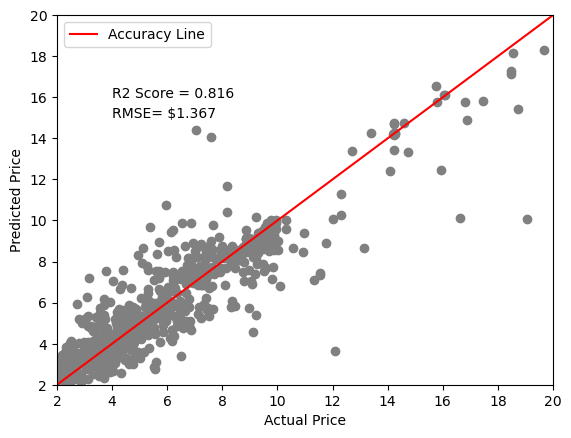

In [30]:
plt.scatter(y_test, rfr.predict(X_test), c = 'Gray')
plt.plot(range(21), range(21), c = 'Red', label = 'Accuracy Line')

plt.xlim(2, 20)
plt.ylim(2, 20)

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.text(4, 16, f'R2 Score = {round(r2_score(y_test, rfr.predict(X_test)), 3)}')
plt.text(4, 15, f'RMSE= ${round(mean_squared_error(y_test, rfr.predict(X_test), squared=False), 3)}')

plt.legend()

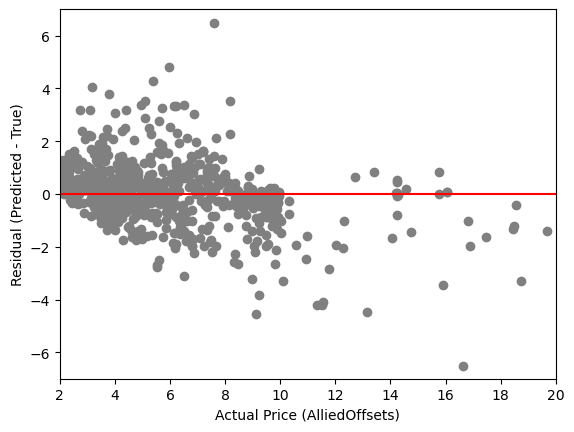

In [31]:
plt.scatter(y_test, rfr.predict(X_test) - y_test, c = 'gray')
plt.ylim(-7, 7)
plt.xlim(2, 20)

plt.xlabel('Actual Price (AlliedOffsets)')
plt.ylabel('Residual (Predicted - True)')

plt.hlines(0, 0, 20, colors = 'red')

In [32]:
model_df['PredictedPrice'] = rfr.predict(model_df.drop(['Registry ID ', 'Avg. Est Transaction Price'], axis=1).values)

In [33]:
# model_df.to_csv('./2023-04-25_PredictedPrice.csv', index=False)

## Residual

In [34]:
model_df['Residual'] = model_df['PredictedPrice'] - model_df['Avg. Est Transaction Price']

In [35]:
np.percentile(model_df['Residual'], 98)

1.6833293333333361

## Q-Q Plot

In [36]:
import statsmodels.api as sm

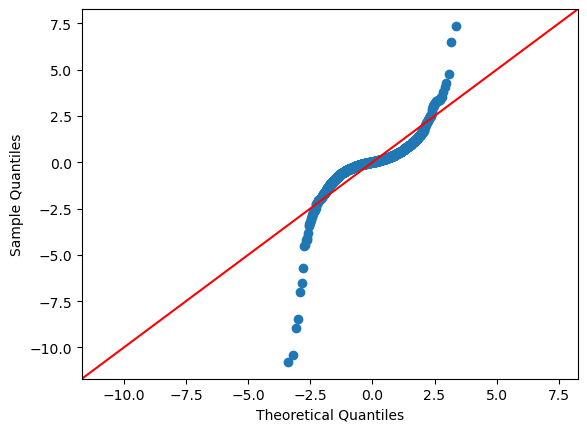

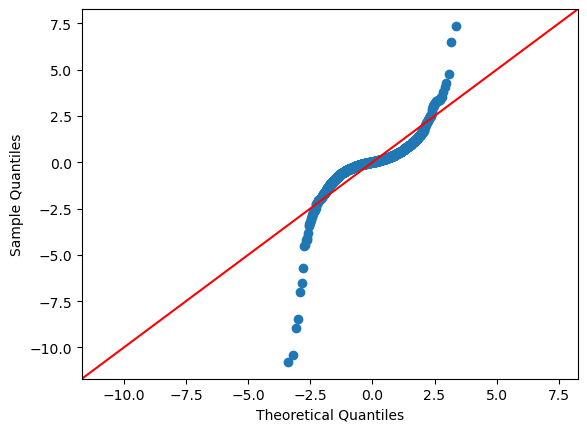

In [37]:
sm.qqplot(model_df['Residual'].values, line='45')

# Cross Validation

In [38]:
kf = KFold(n_splits=8, shuffle=True, random_state=123)

In [39]:
r2 = []
rmse = []
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    print(idx)
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    
    rfr = RandomForestRegressor(n_estimators=300, random_state=123)
    rfr.fit(X_train, y_train)
    
    y_pred = rfr.predict(X_test)
    
    r2.append(r2_score(y_test, y_pred))
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))

0
1
2
3
4
5
6
7


In [42]:
print(f'''
R2 Average = {round(np.mean(r2), 3)}
R2 Std = {round(np.std(r2), 3)}
======
RMSE Average = {round(np.mean(rmse), 3)}
RMSE Std = {round(np.std(rmse), 3)}
''')


R2 Average = 0.806
R2 Std = 0.041
RMSE Average = 1.376
RMSE Std = 0.135



## XGBoost

In [44]:
bst = xgb.XGBRegressor(n_estimators = 500, objective='reg:linear', random_state=123)
bst.fit(X_train, y_train)

[16:59:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [45]:
y_pred = bst.predict(X_test)

In [46]:
print(r2_score(y_test, bst.predict(X_test)))
print(mean_squared_error(y_test, bst.predict(X_test), squared=False))

0.7845272649565709
1.5333490219402208


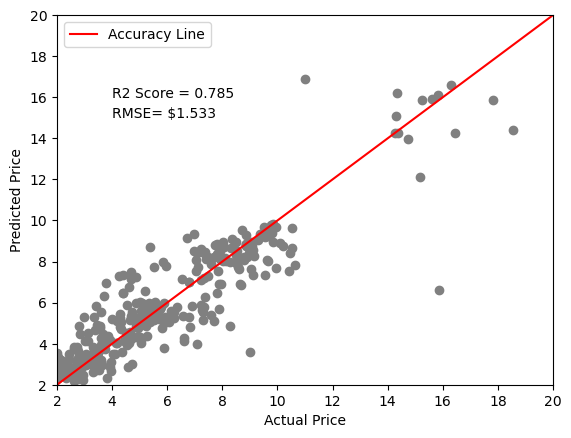

In [47]:
plt.scatter(y_test, rfr.predict(X_test), c = 'Gray')
plt.plot(range(21), range(21), c = 'Red', label = 'Accuracy Line')

plt.xlim(2, 20)
plt.ylim(2, 20)

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.text(4, 16, f'R2 Score = {round(r2_score(y_test, bst.predict(X_test)), 3)}')
plt.text(4, 15, f'RMSE= ${round(mean_squared_error(y_test, bst.predict(X_test), squared=False), 3)}')

plt.legend()